#### Simple ANN model using PCs as input for a model.

File created on April 2, 2025. 

This time I am going to be trying to weight the lat/lon grid before calculating the EOFs per Zheng's suggestions. 

In [1]:
#relevant import statements
import numpy as np
import math
import pandas as pd
import xarray as xr 
import pickle 
#plotting related imports
import matplotlib.pyplot as plt
from matplotlib import rcParams #For changing text properties
from cartopy import crs as ccrs #Useful for plotting maps
import cartopy.util #Requires separate import
from cartopy.util import add_cyclic_point
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.path as mpath
import matplotlib.colors as mcolors

import random
from random import seed
from random import randint
from random import sample

import seaborn as sns # statistical data visualization
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.feature_selection import SelectFromModel

##just to stop the excess number of warnings 
import warnings
warnings.filterwarnings('ignore')

from eofs.standard import Eof

##import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.callbacks import EarlyStopping

tf.compat.v1.disable_eager_execution()
import innvestigate

2025-04-02 15:37:37.408193: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 15:37:37.454314: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-02 15:37:37.454343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-02 15:37:37.455984: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-02 15:37:37.463977: I tensorflow/core/platform/cpu_feature_guar

##### First, I am going to pickle in the input data. I will then remove the seasonal climo from the dataset...

If I were working with one of the lev/lon files here I would take the lat average ... but for PV on the isentropic surface this is unnecessary. 

In [2]:
#load input data
infile = open("/network/rit/lab/langlab_rit/efernandez/Research/Dissertation/AI_Paper/ANN_2025/EOFs/cap_pv350pt.p", 'rb') 
pv_input = pickle.load(infile) ##pv on an isentropic surface, 350 
infile.close()

In [3]:
pv_input.shape ##63 years, october through march, 16 lats (90,60), all lons.

(63, 183, 16, 180)

In [4]:
## remove leap day. 
pv_input = np.delete(pv_input,[151],1)

In [5]:
pv_input[1,150:,0,0]

array([7.82001916, 9.28516056, 9.84458711, 9.82206802, 9.16532372,
       8.47395495, 8.61945045, 8.84344809, 9.11291681, 9.56151052,
       9.01149178, 8.95853645, 8.5347574 , 8.29113287, 8.8833267 ,
       8.91875607, 8.4328276 , 8.78032915, 9.45409101, 9.83351492,
       8.44626356, 8.01245187, 7.47671766, 7.82551524, 7.4089844 ,
       8.444782  , 8.6118107 , 8.58778367, 8.25092866, 7.98703331,
       8.63651803, 7.73850115])

In [6]:
##take seasonal daily average/remove seasonal climatology
dailymean_pv = np.nanmean(pv_input,axis=1)
anom_pv=np.zeros_like(pv_input)
for t in np.arange(pv_input.shape[1]):
     anom_pv[:,t,:,:] = pv_input[:,t,:,:] - dailymean_pv
anom_pv.shape

(63, 182, 16, 180)

In [7]:
##check for NaNs
if np.any(np.isnan(anom_pv)) or np.any(np.isinf(anom_pv)):
    print("NaN or Inf values found in PV!")

In [8]:
anom_pv[:62,21:172,:,:].shape
#anom_pv[:62,31:,:,:].shape

(62, 151, 16, 180)

In [9]:
##flatten pv array 
flat_anom_pv = anom_pv[:62,21:172,:,:].reshape((62*151,16,180))
flat_anom_pv.shape

(9362, 16, 180)

In [10]:
##I DID NOT USE THIS FOR THE EOFs, JUST TRIED TO CALCULATE HERE...
flat_anom = xr.DataArray(data= flat_anom_pv, dims = ["dates","lat","lon"],coords = dict(dates = range(0,9362,1),
                                                                                lat = np.arange(90,58,-2),
                                                                                lon = np.arange(0,360,2)))
wgts = np.cos(flat_anom.lat/180*np.pi)**0.5
flat_anom = flat_anom*wgts
#weights=np.cos(np.deg2rad(flat_anom.lat))
#flat_anom = flat_anom.weighted(weights).mean(dim="lon").mean(dim="lat") #average over the full area
#flat_anom

In [11]:
flat_anom

<xarray.DataArray (dates: 9362, lat: 16, lon: 180)>
array([[[ 3.64247176e-09,  3.64247176e-09,  3.64247176e-09, ...,
          3.64247176e-09,  3.64247176e-09,  3.64247176e-09],
        [ 2.12147938e-01,  2.17419084e-01,  2.24224182e-01, ...,
          1.93594606e-01,  2.00312116e-01,  2.06913596e-01],
        [ 1.05887265e-01,  8.96199192e-02,  7.05591595e-02, ...,
          1.56396945e-01,  1.45620468e-01,  1.26725775e-01],
        ...,
        [ 7.54293496e-01,  5.57327989e-01,  4.93213810e-01, ...,
          9.71047776e-01,  8.39223431e-01,  7.34936303e-01],
        [ 9.38652368e-01,  8.54210126e-01,  6.84922001e-01, ...,
          9.48936419e-01,  1.08572627e+00,  1.11633472e+00],
        [ 8.89917761e-01,  7.84234480e-01,  6.35202154e-01, ...,
          1.26484081e+00,  1.30367729e+00,  9.79364016e-01]],

       [[ 7.42507336e-09,  7.42507336e-09,  7.42507336e-09, ...,
          7.42507336e-09,  7.42507336e-09,  7.42507336e-09],
        [ 2.10719365e-01,  2.07095571e-01,  2.08441916e-01, ...,
          2.14196778e-01,  2.14520369e-01,  2.14097239e-01],
        [ 8.61880626e-02,  9.25197433e-02,  1.02238153e-01, ...,
          7.17293825e-02,  7.44200814e-02,  8.01844622e-02],
...
        [-1.03661135e-01, -1.56211474e-01, -1.73772156e-01, ...,
         -2.55323773e-01, -1.59774424e-01, -1.67850270e-01],
        [-1.82065022e-01, -2.09637563e-01, -5.29431265e-01, ...,
         -6.96220394e-02, -4.49561216e-02,  3.78899394e-02],
        [ 2.22669505e-01, -9.06081031e-03, -1.63200483e-01, ...,
          3.55210631e-01,  1.58222588e-01,  1.89272790e-01]],

       [[ 3.16983926e-09,  3.16983926e-09,  3.16983926e-09, ...,
          3.16983926e-09,  3.16983926e-09,  3.16983926e-09],
        [ 6.03217050e-02,  5.83922268e-02,  5.77624916e-02, ...,
          6.59412973e-02,  6.43107937e-02,  6.30275406e-02],
        [-9.88736686e-02, -1.04764078e-01, -1.09771442e-01, ...,
         -8.30077198e-02, -8.57735954e-02, -9.34385501e-02],
        ...,
        [ 2.58740686e-02,  1.68485533e-01,  3.56569281e-01, ...,
         -4.45585698e-01, -2.04821166e-01, -1.62873312e-01],
        [ 1.40439312e-02,  3.15344317e-01,  5.48803737e-01, ...,
          4.11568612e-01,  2.64794422e-02, -3.36141729e-02],
        [-1.90931817e-01,  1.79000594e-01,  4.58594797e-01, ...,
          2.18938865e-01,  5.09767667e-01,  2.97050117e-02]]])
Coordinates:
  * dates    (dates) int64 0 1 2 3 4 5 6 ... 9355 9356 9357 9358 9359 9360 9361
  * lat      (lat) int64 90 88 86 84 82 80 78 76 74 72 70 68 66 64 62 60
  * lon      (lon) int64 0 2 4 6 8 10 12 14 ... 344 346 348 350 352 354 356 358

##### Now ... attempt at EOF analysis/PC decomp based on Zheng's example code. 

In [13]:
#EOF, the code above had selection of certain pressure levels and latitude bands. I do not need to do that here. 
solver = Eof(flat_anom.values)

In [72]:
##select the desired number of eofs
nmode = 20
EOF = solver.eofs(neofs=nmode,eofscaling=0) 
print(type(EOF),np.shape(EOF))

<class 'numpy.ndarray'> (20, 16, 180)


In [73]:
EOF_nw = EOF #non-weighted, I believe for plotting ... not really relevant here because I did not do that anyways

In [74]:
##make the EOF 2-dimensional
EOF2d = EOF.reshape(EOF.shape[0],EOF.shape[-2]*EOF.shape[-1])
print(np.shape(EOF2d))

(20, 2880)


In [75]:
##I am unclear what is going on here. 
pv = np.dot(EOF2d,np.transpose(EOF2d))
EOF_nw2d = EOF2d
print(pv.shape)

(20, 20)


In [76]:
eigenv = solver.eigenvalues(neigs=nmode)
VarEx = solver.varianceFraction(neigs=nmode)*100
print(sum(VarEx))

54.860551608701044


In [77]:
PC = solver.pcs(npcs=nmode,pcscaling=1)
print(type(PC),np.shape(PC))
del pv
pv = np.dot(np.transpose(PC),PC)
PC.shape

<class 'numpy.ndarray'> (9362, 20)


(9362, 20)

In [78]:
##set lat and lon arrays
lat = np.arange(90,58,-2)
lon = np.arange(0,360,2)
len(lon)

180

In [79]:
## Zheng had sent me an alternative plot sample that used log pressure coordinates. 

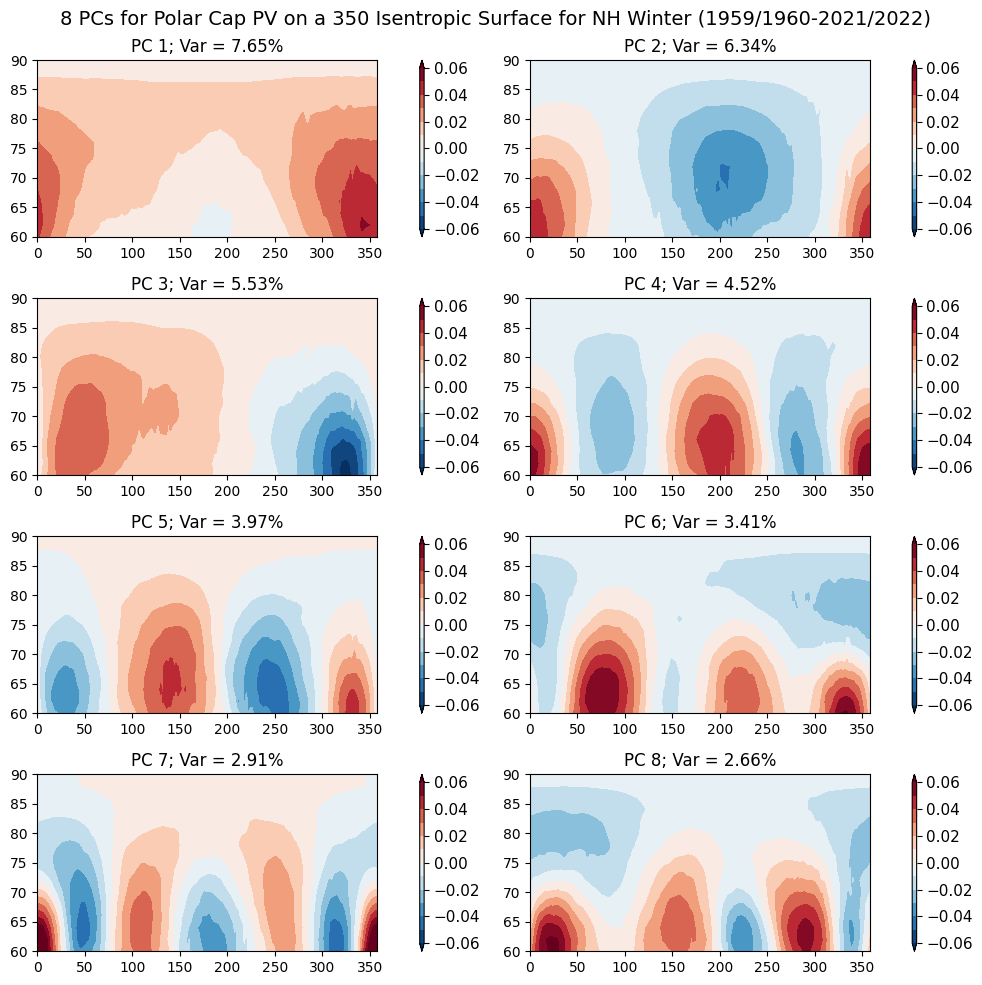

In [80]:
PC_plot = ["PC 1", "PC 2", "PC 3", "PC 4", "PC 5", "PC 6", "PC 7", "PC 8"]
fs = 11 

fig, axes = plt.subplots(4, 2, figsize=(10, 10))
plt.suptitle("8 PCs for Polar Cap PV on a 350 Isentropic Surface for NH Winter (1959/1960-2021/2022)", fontsize = 14)

axes = axes.flatten()
for i in range(0,8):
    color = 'RdBu_r'
    #colorbar options:
    colorbarMin = -0.06
    colorbarMax = 0.06
    colorspace = 0.01
    
    clevel = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)
    axes[i].set_title("PC "+str(i+1)+"; Var = "+str(round(VarEx[i],2))+ "%", fontsize= 12)
    h = axes[i].contourf(lon, lat, EOF_nw[i,:,:], clevel, cmap=color, extend='both', label = str(VarEx[i]))
    cbar = plt.colorbar(h, orientation='vertical', shrink=1,fraction=0.1,pad=0.1,aspect=40)
    cbar.ax.tick_params(labelsize= fs)
    #colorLabel='Z (m)'
    #cbar.set_label(label=colorLabel,fontsize=10)

plt.tight_layout()
plt.subplots_adjust(top=0.93)  
#plt.savefig("First_EOF_8PC_PV.png")

### Now I am going to import temperature data for attempts at running a simple ANN. 

Below is 12 PCs for PV with 10-day lagged temperatures. 1959/1960 to 2020/2021. 

In [81]:
#load output data
infile = open("/network/rit/lab/langlab_rit/efernandez/Research/Dissertation/AI_Paper/ANN_2025/EOFs/classed_europetemps_median.p", 'rb') 
output = pickle.load(infile) ##pv on an isentropic surface, 350 
infile.close()

In [82]:
PC.shape ##this is the input.

(9362, 20)

In [115]:
temp = output.reshape(62,182)
#temp = temp[:,26:177]
temp = temp[:,31:]
temp = temp.reshape(9362,)
temp.shape

(9362,)

In [100]:
##Set X_all and Y_all datasets
X_all = np.copy(PC)
Y_all = np.copy(temp)

##training data partition out
X_tri = X_all[:57*151,:]
Y_tri = Y_all[:57*151]

#testing data partition out
X_tes = X_all[57*151:,:]
Y_tes = Y_all[57*151:]

#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all = keras.utils.to_categorical(Y_all)
Y_tri = keras.utils.to_categorical(Y_tri)
Y_tes= keras.utils.to_categorical(Y_tes)

In [101]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss
if np.any(np.isnan(X_all)) or np.any(np.isinf(X_all)):
    print("NaN or Inf values found in X_all!")

if np.any(np.isnan(Y_all)) or np.any(np.isinf(Y_all)):
    print("NaN or Inf values found in Y_all!")

### Begin setting up parts of my model architecture.

The first few cells here are for partitioning data and setting up lists to save skill scores. 

In [102]:
##set fraction of data as 5 years
frac_ind = 151*5
frac_ind

755

In [103]:
##fraction of training data
X_validation = X_tri[0:frac_ind]
Y_validation = Y_tri[0:frac_ind]
        
X_train = X_tri[frac_ind:len(X_tri)]
Y_train = Y_tri[frac_ind:len(Y_tri)]

X_test = X_tes
Y_test = Y_tes

In [104]:
Y_train.shape

(7852, 2)

In [105]:
##number of input nodes, PCs
numb_int = X_all.shape[-1]
numb_int

20

In [106]:
###### batch, epochs, etc
batch_size = 256 #The number of samples the network sees before it backpropagates (batch size)
epochs = 50 #The number of times the network will loop through the entire dataset (epochs)
shuffle = True #Set whether to shuffle the training data so the model doesn't see it sequentially 
verbose = 2 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

In [107]:
##class weight creator for the instance where now I have a four dimensional output array 
def class_weight_creator(Y):
    class_dict = {}
    Y_reshaped = Y.reshape(-1, Y.shape[-1])
    weights = np.max(np.sum(Y_reshaped, axis=0)) / np.sum(Y_reshaped, axis=0)
    for i in range(Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [108]:
##do the class_dict weights
class_weight = class_weight_creator(Y_train)
class_weight

{0: 1.0, 1: 1.4204686}

In [109]:
##DEFINITION STATEMENT FOR MODEL ITSELF
def basic_ANN(number_inputs,num_cats,n1,n2,rl1,rl2,learn,epochs):
    ##input tensor has the shape of the number of nodes, 777
    input_tensor = Input(shape=(int(number_inputs),))
    #first dense layer
    layer1 = layers.Dense(n1, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= rl1))(input_tensor)
    #second dense layer
    layer1 = layers.Dense(n2, activation='relu',use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2=rl2))(layer1)
    #decay_rate = learn / epochs ###option for decaying learning rate
    #output layer with 2 categories
    output_tensor = layers.Dense(num_cats,activation='softmax')(layer1)
    model = Model(input_tensor, output_tensor)
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learn),
              loss = 'categorical_crossentropy', #Our loss function is based on categorical error
              metrics=[keras.metrics.categorical_accuracy], #We will print out the categorical accuracy as the network is trained
              )
    return model

In [110]:
##Early Stopping Condition, if desired
early_stopping = EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True,verbose=1)

In [111]:
model = basic_ANN(numb_int, 2, 256, 64, 0.005, 0.005, 0.01, epochs)

In [112]:
model.fit(X_train, Y_train, validation_data=(X_validation, Y_validation),
              batch_size=batch_size, epochs=epochs, shuffle=shuffle,
              class_weight = class_weight)#,callbacks=[early_stopping])

Train on 7852 samples, validate on 755 samples
Epoch 1/50
5632/7852 [====================>.........] - ETA: 0s - loss: 3.4531 - categorical_accuracy: 0.5005

2025-04-02 15:50:54.626942: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_10/kernel/Assign' id:1667 op device:{requested: '', assigned: ''} def:{{{node dense_10/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_10/kernel, dense_10/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7852/7852 [==============================] - 0s 25us/sample - loss: 3.0714 - categorical_accuracy: 0.5039 - val_loss: 1.7127 - val_categorical_accuracy: 0.6318
Epoch 2/50
7852/7852 [==============================] - 0s 10us/sample - loss: 1.4120 - categorical_accuracy: 0.5676 - val_loss: 0.9774 - val_categorical_accuracy: 0.5881
Epoch 3/50
7852/7852 [==============================] - 0s 10us/sample - loss: 0.9927 - categorical_accuracy: 0.5926 - val_loss: 0.8015 - val_categorical_accuracy: 0.5589
Epoch 4/50
7852/7852 [==============================] - 0s 10us/sample - loss: 0.8812 - categorical_accuracy: 0.5785 - val_loss: 0.7101 - val_categorical_accuracy: 0.6411
Epoch 5/50
7852/7852 [==============================] - 0s 10us/sample - loss: 0.8431 - categorical_accuracy: 0.5846 - val_loss: 0.6915 - val_categorical_accuracy: 0.6318
Epoch 6/50
7852/7852 [==============================] - 0s 10us/sample - loss: 0.8206 - categorical_accuracy: 0.6000 - val_loss: 0.6747 - val_categorical_ac

In [113]:
train_loss=model.history.history['loss']
val_loss=model.history.history['val_loss']
    
cat_acc=model.history.history['categorical_accuracy']
val_acc=model.history.history['val_categorical_accuracy']
        
pred = model.predict(X_all)
pred_val = model.predict(X_validation)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

2025-04-02 15:50:58.785556: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_11/Softmax' id:1710 op device:{requested: '', assigned: ''} def:{{{node dense_11/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_11/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


<bound method Axes.legend of <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Acc'>>

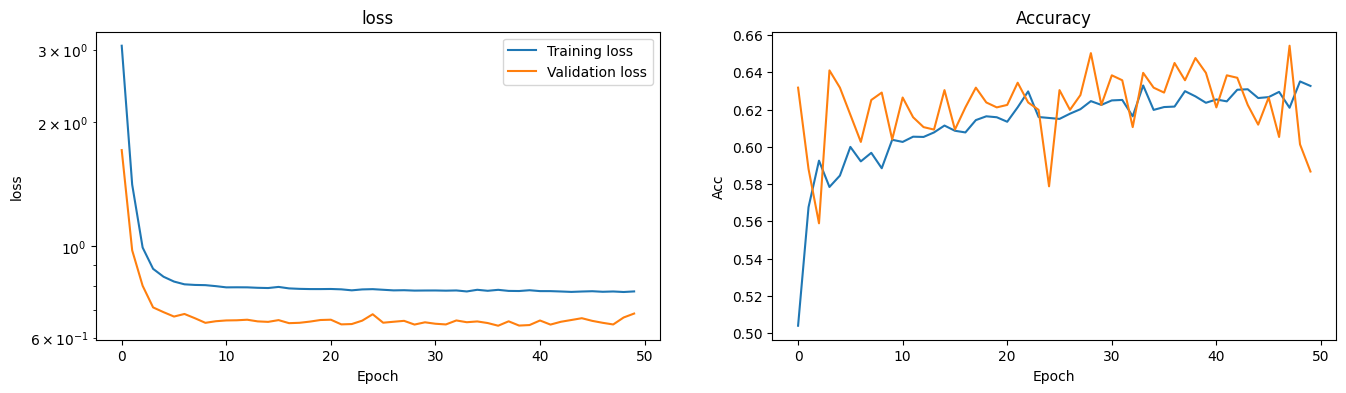

In [114]:
# Look at the optimization history
fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.25))
ax1.plot(train_loss, label='Training loss')
ax1.plot(val_loss, label='Validation loss')
ax1.set_yscale('log')
ax1.set_title('loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(cat_acc, label='Training ACC')
ax2.plot(val_acc, label='Validation ACC')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Acc')
ax2.legend